In [ ]:
import torch 
import torch.nn as nn
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import torch.nn.functional as F
from tqdm.notebook import tqdm
from ignite.metrics.nlp import Bleu
import string, re
from string import punctuation
import time, math, random
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer("basic_english")

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output

import spacy
nlp = spacy.load("en_core_web_sm")

import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [3]:
class AnnotatedDataset(Dataset):
    
    def __init__(self, data):
        self.df = data
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Annotation dataset columns
        # 0:prem, 1:hypo, 2:premise_pos, 3:premise_dep, 4:adj_list, 5:hypothesis_pos, 6:hypothesis_dep
        return row[0], row[1], row[3].split(), eval(row[4])
    
    @classmethod
    def load_dataset(cls, path):
        """Load a train partition of the SNLI dataset with pos and dependency tags
        
        Args:
        path (str): path to SNLI dataset 

        Returns:
        an instance of Dataset
        """
        data = pd.read_csv(path)
    
        return cls(data)

In [21]:
class OriginalDataset(Dataset):

    def __init__(self, data):
        self.df = data
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        pair = self.df.iloc[idx]
        return pair[0], pair[1]

    @classmethod
    def load_dataset(cls, path, split):
        """Load a specified partition of the SNLI dataset
        
        Args:
        path (str): folder where the snli dataset is located
        split (str): one of "train", "dev", or "test"
        
        Returns:
        an instance of Dataset
        """
        data = pd.read_table(f"{path}\snli_1.0_{split}.txt", delimiter ="\t", index_col = "gold_label")\
             .loc[["entailment"], ["sentence1", "sentence2"]].dropna()
    
        return cls(data)

In [11]:
def word_tokenizer(text):
    """ Minimal sentence cleaning and tokenization."""
    
    text = re.sub("-", " ", text)
    tokens = [w if w in punctuation else re.sub("[" + punctuation + "]", "", w) for w in tokenizer(text)]
    return tokens


def yield_tokens(data_iterator):
    " Generator yields one list of tokens from one premise-hypothesis pair. "
    
    for row in data_iterator:
        yield (row[0]+ " " + row[1]).split()
        
        
def build_vocabulary(train_data):
    """Extracts vocabulary from training data
    
    Args:
    train_data (str, str): training dataset
    
    Returns:
    vocabulary object
    """
    
    vocabulary = build_vocab_from_iterator(yield_tokens(train_data), specials = ["<unk>", "<sos>", "<eos>"])
    vocabulary.insert_token("<pad>", 0)
    vocabulary.set_default_index(vocabulary["<unk>"])
    return vocabulary

def simple_sentence2tensor(sentence):
    """ 
    Encodes tokens with indices;
    appends <EOS> token;
    transforms into a torch.tensor.
    
    Args:
    sentence (str): row string 
    
    Returns:
    vectorized sentence
    """
    indices = [vocabulary[word] for word in sentence.split()]
    indices.append(vocabulary["<eos>"])
    return torch.tensor(indices)

def sentence2tensor(sentence):
    """ 
    Encodes tokens with indices;
    appends <EOS> token;
    transforms into a torch.tensor.
    
    Args:
    sentence (str): row string 
    
    Returns:
    vectorized sentence
    """
    indices = [vocabulary[word] for word in word_tokenizer(sentence)]
    indices.append(vocabulary["<eos>"])
    return torch.tensor(indices)


def dependency2tensor(dependency_list):
    """ 
    Encodes tags with indices;
    transforms into a torch.tensor.
    
    Args:
    sentence (list): list of tags
    
    Returns:
    vectorized dependencies
    """
    indices = [tag2idx[tag] for tag in dependency_list] + [tag2idx["<eos>"]]
    return torch.tensor(indices)

def collate_batch(batch):
    """
    Encodes each pair of raw sentences and converts into torch.tensors;
    records the corresponding lengths for both premise and hypothesis;
    pads premise tensors to the max premise length in a batch;
    pads hypothesis tensors to the max hypothesis length in a batch.

    Args:
    A batch with premise-hypothesis pairs, dependency tags for premise and adjacency edges (dependency relations)
    
    Returns: a dictionary 
    padded_prem: tensor with size (batch_size, max_premise_len) , each premise is a vector of token indices [x1, x2,..., <eos>]
    padded_hypo: tensor with size (batch_size, 1 + max_hypothesis_len), each hypothesis is a vector of token indeces [<sos>, y1, y2,..., <eos>]
    premise_lengths: tensor with size (batch_size)
    hypothesis_lengths: tensor with size (batch_size)
    prem_dep: tensor with size (batch_size, max_premise_len)
    adj_list: list of lists of tuples representing adjacency edges
    
    """
    premise, hypothesis, prem_lengths, hypo_lengths, dep_tags, adj_list= [],[],[],[],[],[]
    
    for prem, hypo, dep_prem, dep_adj in batch:
        
        encode_prem = simple_sentence2tensor(prem) # indexed tensor + eos_token
        encode_hypo = simple_sentence2tensor(hypo) # indexed tensor + eos_token
        premise.append(encode_prem)
        hypothesis.append(encode_hypo)
        
        prem_lengths.append(encode_prem.size(0))
        hypo_lengths.append(encode_hypo.size(0))
        
        dep_tags.append(dependency2tensor(dep_prem))
        adj_list.append(dep_adj)
        
    # padding sequences to max_sequence_length
    padded_prem = nn.utils.rnn.pad_sequence(premise, batch_first = True)
    padded_hypo = nn.utils.rnn.pad_sequence(hypothesis, batch_first = True)
    pad_dep_prem = nn.utils.rnn.pad_sequence(dep_tags, batch_first = True)
    
    # prepend <sos> token to hypothesis sequences
    sos_tensor =  torch.tensor([vocabulary["<sos>"]]).repeat(padded_hypo.size(0), 1)
    padded_hypo = torch.cat((sos_tensor, padded_hypo), dim = -1)
    
    return {"premise": padded_prem,
            "hypothesis": padded_hypo,
            "premise_lengths": torch.tensor(prem_lengths),
            "hypothesis_lengths": torch.tensor(hypo_lengths),
            "prem_dep": pad_dep_prem,
            "adj_list": adj_list
           }

def generate_batches(dataset,
                     batch_size=32,
                     collate_fn = collate_batch,
                     shuffle=True,
                     drop_last=True,
                     device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
    ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, 
                            batch_size=batch_size, 
                            collate_fn = collate_fn,
                            shuffle=shuffle,
                            drop_last=drop_last)
    
    for batch_dictionary in dataloader:
        out_batch_dictionary = {}
        for name, tensor in batch_dictionary.items():
            if name != "adj_list":
                out_batch_dictionary[name] = batch_dictionary[name].to(device)
            else:
                out_batch_dictionary[name] = batch_dictionary[name]
        yield out_batch_dictionary

        
def create_w2v_matrix(vocabulary, wv):
    """ Initializes an embedding matrix for vocabulary words
    with word2vec pretrained vectors or random vectors when no pretrained vector exist.
    
    Args:
    vocabulary : vocabulary object
    wv : pretrained word2vec vectors
    
    Returns:
    word embedding matrix with shape (vocabulary_size, 300)
    """
    w2v_embeddings = np.zeros((len(vocabulary), 300))
    words_not_found = set()
    n_words_not_found = 0

    for i, (word, idx) in enumerate(sorted(vocabulary.get_stoi().items(), key=lambda x:x[1])):
    
        try:
            w2v_embeddings[i] = wv[word]
            
        except KeyError:
            words_not_found.add(word)
            n_words_not_found += 1
            w2v_embeddings[i] = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=(300,))
        
    print("Number of words not found in pretrained w2v model:", n_words_not_found)
    w2v_embeddings = torch.Tensor(w2v_embeddings)
    return w2v_embeddings


def count_parameters(model):
    """ Counts the number of learnable parameters in the model"""
    return sum(param.numel() for param in model.parameters() if param.requires_grad)


def init_weights(model):
    """ Initializes weights of the model (except for pretrained embeddings) 
        with random values in a predefined interval. """
    for name, param in model.named_parameters():
        if name != "embedding.weight":
            nn.init.uniform_(param, -0.08, 0.08)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
def train(model,
          train_data,
          optimizer,
          criterion,
          train_history=None, valid_history=None):
    
    model.train()
    iteration, epoch_loss = 0, 0
    history = []

    for batch_dictionary in tqdm(generate_batches(train_data, device = device)):  
        
        iteration += 1
        
        # reset gradients
        model.zero_grad()
                
        # compute output 
        log_probs = model(*batch_dictionary.values())
        num_classes = log_probs.size(-1) 
        
        # compute loss for a batch
        batch_loss = criterion(log_probs.view(-1, num_classes), 
                               batch_dictionary["hypothesis"][:, 1:].contiguous().view(-1))
        epoch_loss += batch_loss.item()
        batch_loss.backward()
        
        # clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        # update parameters
        optimizer.step()
        
        # logging and reporting
        history.append( epoch_loss / iteration )
        
        if iteration % 100 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()
            
    return epoch_loss / iteration

In [17]:
def greedy_decoder(decoder, annotations, encoder_hidden):
    
    """ Generates a hypothesis for a given premise.
    Args:
    decoder: decoder component of seq2seq model
    annotations: tensor with shape (1, seq_len, hidden_size) # contextualized encoding of premise 
    encoder_hidden: tensor with shape (2, 1, hidden_size) # final hidden state from encoder LSTM

    Returns:
    decoded_sentence: str
    attention_weights: array with size (hypothesis_len, premise_len)
    """
    # initiate decoder hidden_state with encoder final hidden state
    decoder_hidden = encoder_hidden

    # create a tensor for <sos> token and a tensor for token length
    token_len = torch.tensor([1]).to(device)
    input_word = torch.tensor([vocabulary["<sos>"]]).view(1, 1).to(device)
  
    decoded_hypothesis, attention_weigths = [], []

    # start to decode a sequence of at most 20 tokens
    for step in range(20):

        # embed a word of the target sequence
        decoder_input = model.embedding(input_word)
        
        # compute probability distribution, hidden state, and attention
        probabilities, decoder_hidden, att_weight = \
         decoder(decoder_input, token_len, annotations, decoder_hidden)
        attention_weigths.append(att_weight.squeeze().cpu().numpy())
        
        # decode the word with max probability score, stop if it is <eos> token
        _, topi = probabilities.data.topk(1)
        topi = topi.view(-1)
        decoded_word = vocabulary.lookup_tokens([int(topi)])[0]
        if decoded_word == "<eos>":
            break
    
        input_word = topi.detach().view(-1, 1)
        decoded_hypothesis.append(decoded_word)

    return np.array(attention_weigths), " ".join(decoded_hypothesis)


def predict(premise, model): 
    
    """ Implements greedy decoding to generate the hypothesis for a given premise.
      Args:
      premise: str
      model: seq2seq model trained to perform inferences
    
      Returns:
      decoded_sentence: str
      attention_weights: array with size (hypothesis_len, premise_len)
      """
  
    # get dpendency tags and adjacency edges
    tokens, dep, IDs_dependent, IDs_head = \
    zip(*[(tok.text, tok.dep_, tok.idx, tok.head.idx) for tok in nlp(" ".join(word_tokenizer(premise)))])
    adj_list = [(idx_dep, IDs_dependent.index(id_head)) for idx_dep, id_head in enumerate(IDs_head)]
    
    premise_tensor = simple_sentence2tensor(" ".join(tokens)).view(1, -1).to(device)
    premise_len = torch.tensor([premise_tensor.size(1)]).to(device)
    tag_tensor = dependency2tensor(dep).view(1, -1).to(device)
    adj_list = list([adj_list])
    
    model.eval()
        
    with torch.no_grad():

        # embed premise and tags
        prem_embed = model.embedding(premise_tensor) 
        tags_embed = model.dep_embedding(tag_tensor)
        
        annotations, hidden_encoder = model.encoder(prem_embed, tags_embed, premise_len, adj_list)
        att_weights, decoded_sentence = greedy_decoder(model.decoder, annotations, hidden_encoder)
        
    return decoded_sentence, att_weights

## Linguistically Informed Encoder

The most immediate way to include linguistic information about syntactic dependecies into the Seq2Seq model,
is to provide as input to the encoder both the embeded representation of premise tokens and their parent tokens,
together with their dependency tag. A special function is used to retrieve parent tokens for each input token in the premise. All the three embedding vectors are concatenated and supplied to the bidirectional LSTM to extract useful feature representation of the input sentence.
The output from the encoder is a sequence of contexualized and linguistically informed representations for each word in the input sentence.
The final hidden state from the encoder initiates the hidden state of the decoder in the first time step.

The decoder uses a 2-layer LSTM to encode the output sentence. With teacher forcing we can optimize the training process and encode the whole output sequence at one. Attention layer on top of the LSTM layer, implements dot product to evaluate compatibility between contextualized representetions from the encoder LSTM and contextualized representations ptoduced by the decoder. The context vector ouput from the attention layer is concatenated with the corresponding hidden representation and fed through two feed-forward layers with softmax activation at the end to produce the probability distribution over the vocabulary.



In [5]:
class Encoder(nn.Module):
    def __init__(self,
                 word_embed_size,
                 hidden_size,
                 n_layers,
                 dropout,
                 device):
        super().__init__()
        
        self.embed_size = 2*word_embed_size + 64
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bilstm = nn.LSTM(self.embed_size,
                              self.hidden_size,
                              num_layers = self.n_layers,
                              bidirectional = True,
                              batch_first = True,
                              dropout = dropout)
        
        self.dropout = nn.Dropout(p = dropout)
        
    def dependency_head(self, batch, edges_list):
        """ Retrieves dependency parent for each token in a batch of input sentences
        Args:
        batch: tensor with shape (batch_size, seq_len, word_embed_size)
        edges_list: list of lists of tuples (token.idx, head.idx)

        Returns:
        A batch of token parent sequences
        size (batch_size, seq_len, word_embed_size)
        """
        tag_mask = []
        for idx in range(batch.size(0)):
            # create a square matrix to fill-in for each sequnce in a batch
            adj_matrix = torch.zeros(batch.size(1), batch.size(1))
            for dependent, head in edges_list[idx]:
                adj_matrix[dependent, head] = 1
            tag_mask.append(adj_matrix)

        # creating a batch of stacked tag-mask matrices
        tag_mask = torch.stack(tag_mask) 
        head_vectors = torch.bmm(tag_mask.to(device, dtype = torch.float32), batch)
        return head_vectors
      
    def forward(self, prem_embed, tags_embed, prem_length, adj_list):
        # prem_embed: tensor with shape [batch_size, seq_len, word_embed_size] 
        # tags_embed: tensor with shape [batch_size, seq_len, tags_embed_size]
        # prem_length: tensor with shape [batch_size, seq_len]
        # adj_list: list of lists of tuples 
    
        # retrieve parent tokens and concat premise tokens, parent tokens and tags embeddings
        # syntax_embed size [batch_size, seq_len, 664]
        dependency_heads = self.dependency_head(prem_embed, adj_list)
        syntax_embed = torch.cat((prem_embed, tags_embed, dependency_heads), dim=-1)
        syntax_embed = self.dropout(syntax_embed)

        # Handling padding in Recurrent Networks
        prem_packed = nn.utils.rnn.pack_padded_sequence(syntax_embed,
                                                        prem_length.cpu(),
                                                        enforce_sorted = False,
                                                        batch_first = True)
        
        # lstm_state is a tuple (hidden, cell) with shape : [4, batch_size, hidden_size] 
        # lstm_out with shape : [batch_size, seq_len, 2*hidden_size]
        lstm_out, lstm_state = self.bilstm(prem_packed)  
        
        # pad lstm output to have same length sequences in a batch
        encoded_premise = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)[0] 
        
        # resize from [num_layers * n_directions, batch_size, hidden_size] to [num_layers, batch_size, 2*hidden_size]
        hidden = lstm_state[0].reshape(self.n_layers, 2, -1, self.hidden_size)\
            .transpose(1,2).reshape(self.n_layers, -1, 2*self.hidden_size)
        cell = lstm_state[1].reshape(self.n_layers, 2, -1, self.hidden_size)\
            .transpose(1,2).reshape(self.n_layers, -1, 2*self.hidden_size)
        
        # hidden and cell of size [num_layers, batch_size, 2*hidden_size] = [2, 32, 512]
        # encoded_premise of size [batch_size, seq_len, 2*hidden_size] 
        return encoded_premise, (hidden, cell)

In [6]:
class DecoderDot(nn.Module):
    def __init__(self,
                 pretrained_w2v,
                 hidden_size,
                 n_layers, 
                 dropout,
                 device
                 ):
        super().__init__()
        self.num_classes = pretrained_w2v[0]
        self.embed_size = pretrained_w2v[1]
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.embed_size,
                            self.hidden_size,
                            num_layers = n_layers,
                            batch_first = True, 
                            dropout = dropout)
        
        self.W_a = nn.Linear(self.hidden_size*2, self.hidden_size, bias = True)
        self.W_s = nn.Linear(self.hidden_size, self.num_classes, bias = True)
        self.dropout = nn.Dropout(dropout)
        
    def attention_layer(self, hidden_target, annotations, mask = None):
        # hidden_target: tensor with shape [batct_size, hypo_len, hidden_size]
        # annotations: tensor with shape [batch_size, prem_len, hidden_size]
        # mask: tensor with shape [batch_size, 1, prem_len]
        
        hidden_target = hidden_target.view(annotations.size(0), -1, self.hidden_size).contiguous()
        energy = torch.bmm(hidden_target, annotations.permute(0,2,1))
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        # energy with shape [batch_size, hypo_len, prem_len]          
        align_score = F.softmax(energy, dim = -1)
        expected_annotation = torch.bmm(align_score, annotations)
        
        # align_score with shape [batch_size, target_len, source_len]
        # expected_annotation with shape [batch_size, target_len, hidden_size]
        return align_score, expected_annotation
    
        
    def forward(self, hypothesis_batch, hypo_len, annotations, prev_state, mask = None):
        # hypothesis_batch: tensor with shape [batch_size, seq_len]
        # annotations: tensor with shape [batch_size, seq_len, hidden_size]
        # prev_state: tuple with shape ([2, batch_size, hidden_size], [2, batch_size, hidden_size])
        # mask(optional): tensor with shape [batch_size, 1, prem_len]
        
        # hypothesis_embedding with shape [batch_size, seq_len, word_embed_size]
        hypothesis_embedding = self.dropout(hypothesis_batch)
      
        # Handling padding in Recurrent Networks
        hypo_packed = nn.utils.rnn.pack_padded_sequence(hypothesis_embedding,
                                                        hypo_len.cpu(),
                                                        enforce_sorted = False,
                                                        batch_first = True)
        
        # lstm_state with shape [num_layers, batch_size, hidden_dim] 
        lstm_out, lstm_state = self.lstm(hypo_packed, prev_state) 
        
        # unpacked_lstm_out = [batch_size, seq_len, hidden_dim] = [32, seq_len, 512]
        unpacked_lstm_out = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first = True)[0] 
        
        # attention_weights is a matrix of similarities with shape [batch_size, target_len, source_len]
        # expected_annotation is a context vector for each target word with shape [batch_size, target_len, hidden_size]
        attention_weights, expected_annotation = self.attention_layer(unpacked_lstm_out, annotations, mask)
        
        # att_hidden with shape [batch_size, seq_len, hidden_size]
        context_vector = torch.cat((expected_annotation, unpacked_lstm_out), dim = -1)
        att_hidden = self.dropout(torch.tanh(self.W_a(context_vector)))
        
        # probabilities with shape [batch_size x seq_len x vocab_size]
        log_probs = F.log_softmax(self.W_s(att_hidden), dim = -1)
        return log_probs, lstm_state, attention_weights

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 pretrained_w2v,
                 hidden_size,
                 n_layers,
                 tags_embed = 64,
                 dropout = 0.1,
                 device = "cpu" ):
        super().__init__()
        
        self.dep_embedding = nn.Embedding(len(tag2idx), tags_embed, padding_idx = 0)
        self.embedding = nn.Embedding.from_pretrained(embeddings = pretrained_w2v,
                                                      freeze = False,
                                                      padding_idx = 0)
        
        self.encoder = Encoder(pretrained_w2v.size(1), hidden_size//2, n_layers, dropout, device = device)
        self.decoder = DecoderDot(pretrained_w2v.size(), hidden_size, n_layers, dropout, device = device)
        self.device = device
        
    @staticmethod
    def create_mask(seq):    
        # Input: seq = [batch size, seq len]
        # Output: mask = [batch size, 1, seq len]
        mask = (seq != 0).unsqueeze(1)
        return mask

        
    def forward(self, premise, hypothesis, prem_length, hypo_length, prem_dep, adj_list):
        
        # create a mask for padded positions in input sequences
        prem_mask = Seq2Seq.create_mask(premise).to(device)
        # slice hypothesis, dropping the last position token.
        hypothesis = hypothesis[:,:-1].contiguous()
        
        # Embded premise, hypothesis and dependency tags
        prem_embed = self.embedding(premise)
        hypo_embed = self.embedding(hypothesis)
        prem_dep_embed = self.dep_embedding(prem_dep)
        
        encoder_out, encoder_state = self.encoder(prem_embed,
                                                  prem_dep_embed,
                                                  prem_length,
                                                  adj_list)
        
        log_probs, decoder_state, _ = self.decoder(hypo_embed,
                                                   hypo_length,
                                                   encoder_out,
                                                   encoder_state, 
                                                   prem_mask)
        return log_probs

## Load data

- Loading training dataset with annotations.
- create vocabulary
- create embedding matrix from pretrained Word2Vec vectors
- build a mapping from tags to indices

In [12]:
config = {"data_path" : r"D:\Huawei Share\Download", 
          "batch_size" : 32}

train_data = AnnotatedDataset.load_dataset(r"C:/Users/dashb/Downloads/Information retrieval/SNLI.csv")
vocabulary = build_vocabulary(train_data)
w2v_embeddings = create_w2v_matrix(vocabulary, wv)

# create a tag-to-index mapping for dependency tags
tags_list = list(set(itertools.chain(*[set(row[2]) for row in train_data])))
tags_list = ["<pad>", "<unk>"] + tags_list + ["<eos>"]
tag2idx = {tag:idx for idx, tag in enumerate(tags_list)}

Number of words not found in pretrained w2v model: 2616


## Train Seq2Seq model

In [15]:
SEED = 1234

import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

HID_DIM = 512
N_LAYERS = 2
TAGS_EMBED = 64
DROPOUT = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using", device)

# create an instance of seq2seq model and transfer to device
model = Seq2Seq(w2v_embeddings, HID_DIM, N_LAYERS, TAGS_EMBED, DROPOUT)
model = model.to(device)
        
# initialize model parameters
model.apply(init_weights)
print(f'The seq2seq model has {count_parameters(model):,} trainable parameters')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss(ignore_index = 0)

cuda
The seq2seq model has 25,314,078 trainable parameters


### Load the checkpoint or train

In [ ]:
checkpoint = torch.load(r"D:\Huawei Share\Download\inPROGRESS\Attention_LIA.tar")
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
model = model.to(device)

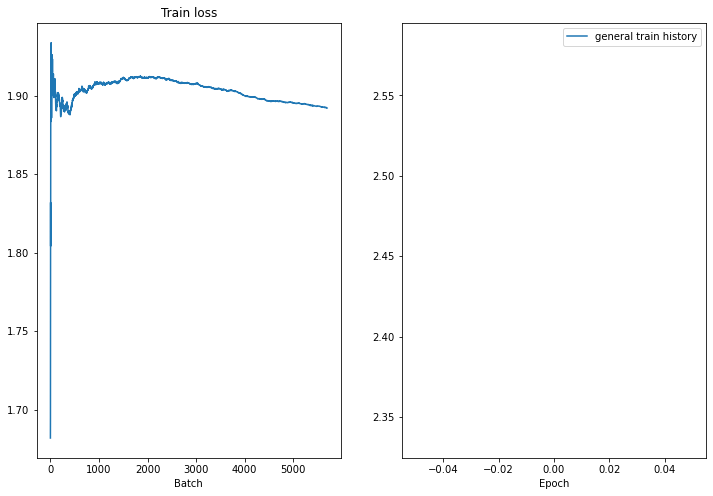


Epoch: 02 | Time: 47m 6s
	Train Loss: 1.892 


In [18]:
torch.cuda.empty_cache()

train_history = []
N_EPOCHS = 2

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    train_loss = train(model, train_data, optimizer, criterion, train_history)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_history.append(train_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} ')

In [28]:
torch.save({'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, r"D:\Huawei Share\Download\inPROGRESS\Attention_LIA.tar")

## Evaluation and Visualization

In [22]:
test_data = OriginalDataset.load_dataset(config["data_path"], split = "test")

### Display attention heat maps

In [23]:
import matplotlib.ticker as ticker

def display_attention(premise, hypothesis, attention):
    fig = plt.figure(figsize = (15,30))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attention, cmap='bone')
    
    # Set up axes
    ax.tick_params(labelsize =12)
    #pos_tags = [tok.pos_ for tok in nlp(" ".join(word_tokenizer(premise)))]
    ax.set_xticklabels([""] + word_tokenizer(premise) + ['<EOS>'], rotation=60)
    ax.set_yticklabels( [""] + hypothesis.split(" ")+['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Sample n. 3305


<ipython-input-23-f34a187b3ce7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + word_tokenizer(premise) + ['<EOS>'], rotation=60)
<ipython-input-23-f34a187b3ce7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels( [""] + hypothesis.split(" ")+['<EOS>'])


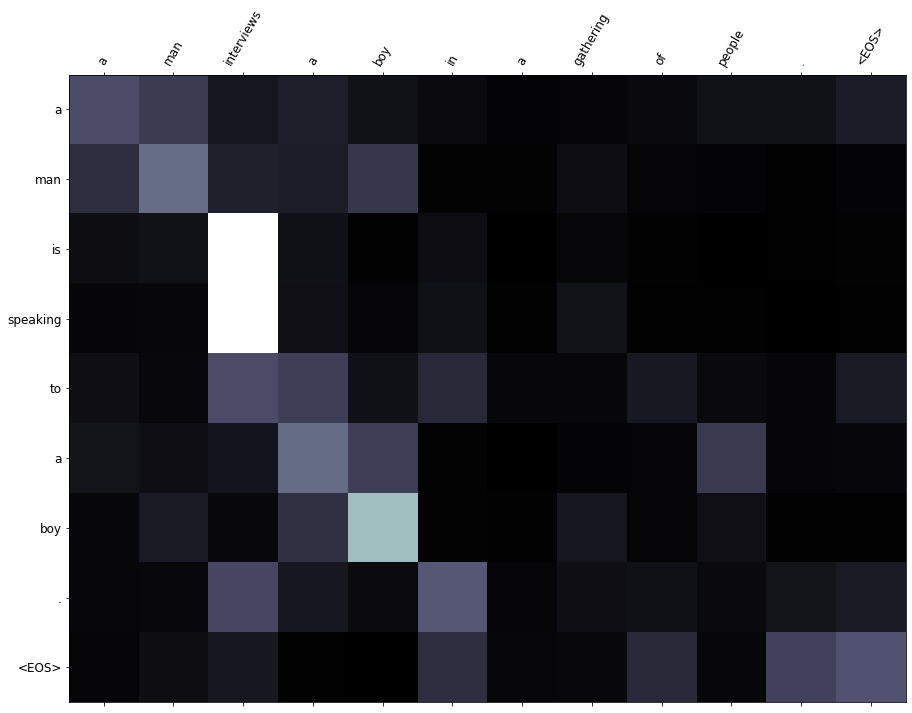

Sample n. 2384


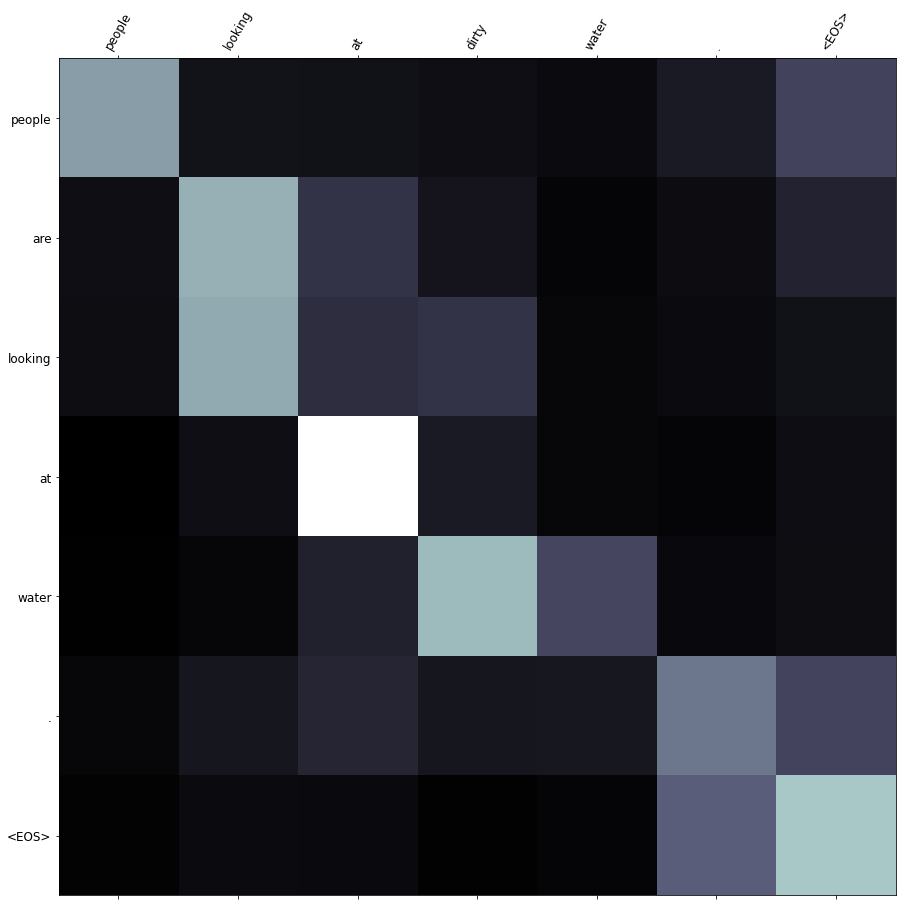

Sample n. 143


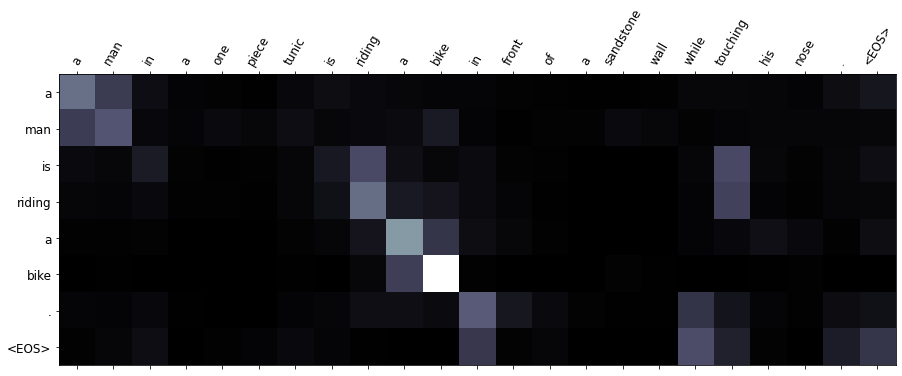

Sample n. 2750


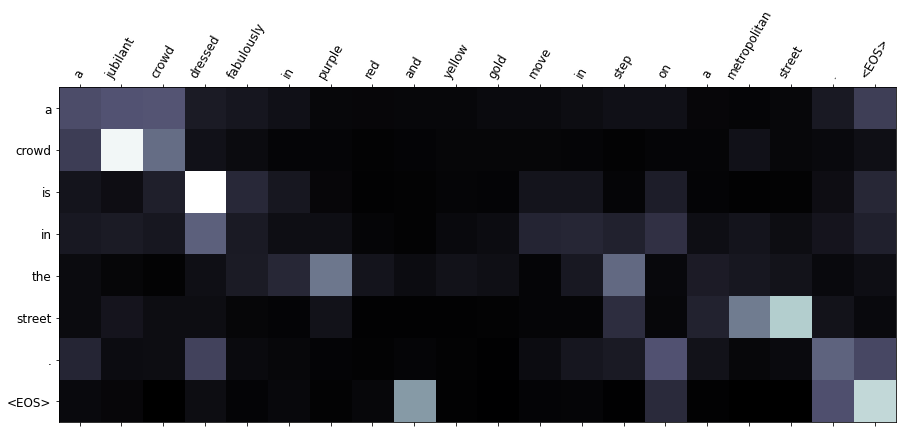

Sample n. 2838


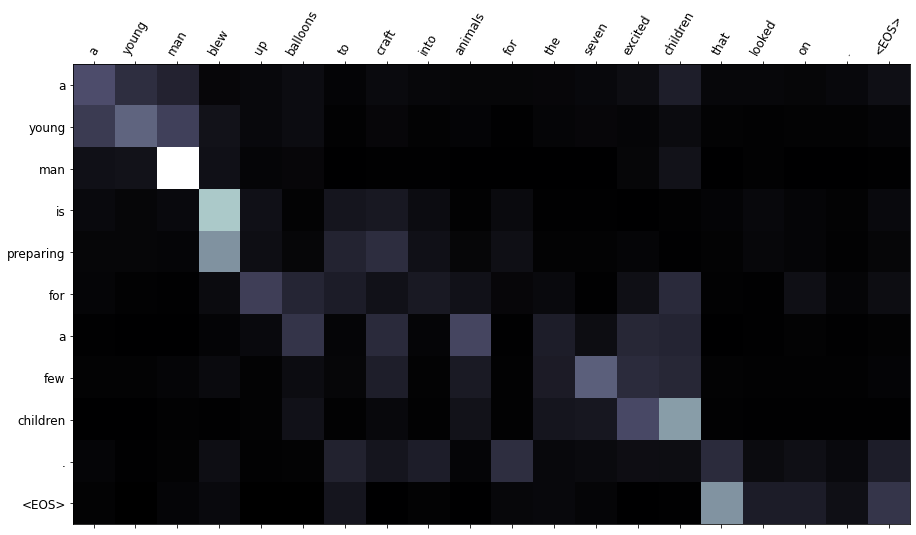

In [25]:
for index in random.sample(range(len(test_data)), k=5):
    print("Sample n.", index)
    premise, hypothesis = test_data[index]

    # predict the corresponding hypothesis
    pred_hypothesis, att_weights  = predict(premise, model)
    display_attention(premise, pred_hypothesis, att_weights)

### Evaluation with RoBERTa

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
RobertaTokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli')
RobertaModel = RobertaForSequenceClassification.from_pretrained('roberta-large-mnli')

def roberta_classify(premise, generated_hypo):
    # adapted from https://github.com/ufal/nlgi_eval/blob/master/nli_eval.py
    
    inputs = RobertaTokenizer("%s </s></s> %s" % (premise, generated_hypo), return_tensors="pt")
    labels = torch.tensor([1]).unsqueeze(0)  # create a batch dim of 1
    output = RobertaModel(**inputs, labels=labels) 
    # output contains loss, logits
    
    probs = F.softmax(output[1], dim=1).detach().numpy()[0]
    return  probs # [contradiction, neutral, entailment]

In [ ]:
bleu = Bleu(ngram = 4, smooth ="smooth1") # Bleu class from ignite.metrics
mapping = { 0: "contradiction", 1:"neutral", 2: "entailment"}

semantic_accuracy, sample = 0, 0
bleu_scores, false_entailment = [], []

for index, row in enumerate(test_data):
    print("Sample n.", index)
    premise, hypothesis = test_data[index]
    #convert premise into sequence of ids 

    # predict the corresponding hypothesis
    pred_hypothesis, att_weights = predict(premise, model)
 
    print("> Premise:", premise, sep = "\n")
    print("> Generated hypothesis:", pred_hypothesis)
    
    
    # Use ROBERTA to check if generated hypothesis is entailed 
    classification_roBERTa = np.argmax(roberta_classify(premise, pred_hypothesis))
 
    if classification_roBERTa != 2 :
        entailment_check = 0
        false_entailment.append((index, premise, pred_hypothesis))
    else: 
        entailment_check = 1
        
    print("Classified as:", mapping[classification_roBERTa])
    semantic_accuracy += entailment_check
    
    # create list of tokens for premise and hypothesis
    tokens_hypothesis = pred_hypothesis.split()
    tokens_references = list(map(word_tokenizer, [premise, hypothesis]))
    
    # Computing the blue score:
    # update the blue function with a tuple (list of hypothsis, list of premises)    
    bleu.update(([tokens_hypothesis], [tokens_references]))
    bleu_score = bleu.compute().item()
    bleu_scores.append(bleu_score)
    bleu.reset()
    print()
    print("Bleu score:", bleu_score)
    print("__________________________________________________________")  
    
    
print("Macro-Average precision with sentence-level Blue score:", np.mean(bleu_scores)*100)
print("Semantic accuracy", (semantic_accuracy / index)*100 )

In [ ]:
false_entailment

### Draw alignments

In [26]:
def draw_alignment(premise, decoded_hypothesis, attention_weights, THRESHOLD_ATTENTION = 0.1, tag = None):
               
    #- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # DEFINE THE BIPARTITE GRAPH 
    
    def get_source_target_labels(PREM, HYPO, tag = tag):
        # PREM : str
        # HYPO : str
        PREM = " ".join(word_tokenizer(PREM))
        if tag == None:
            tokenized_prem = PREM.split() + ['<eos>']
            tokenized_hypo = HYPO.split() + ['<eos>']
            return tokenized_prem, tokenized_hypo
        
        elif tag == "pos_tag":
            pos_prem = [tok.pos_ for tok in nlp(PREM)] + ['<eos>']
            pos_hypo = [tok.pos_ for tok in nlp(HYPO)] + ['<eos>']
            return pos_prem, pos_hypo
        
        elif tag == "dep_tag":
            dep_prem = [tok.dep_ for tok in nlp(PREM)] + ['<eos>']
            dep_hypo = [tok.dep_ for tok in nlp(HYPO)] + ['<eos>']
            return dep_prem, dep_hypo
    
    src_labels, trg_labels = get_source_target_labels(premise, decoded_hypothesis)
    
    G = nx.DiGraph()
    
    # indices of nodes in premise and hypothesis
    nodes_source = range(1, len(src_labels) + 1)
    nodes_target = range(len(src_labels) + 1, len(src_labels + trg_labels) + 1)
    
    # add nodes to the graph
    G.add_nodes_from(nodes_source, bipartite = "src")
    G.add_nodes_from(nodes_target, bipartite = "trg") 
    
    # add word label attribute to source and target nodes
    nx.set_node_attributes(G, dict(zip(G.nodes, src_labels)), "word")
    for i, node in enumerate(nodes_target):
        G.nodes[node]["word"] = trg_labels[i]   
    
    # retrieve words to represent labels for nodes
    # labels : dict {1: 'this', 2: 'church', 3: 'choir', 4: 'sings',... }
    labels = nx.get_node_attributes(G, 'word')
    
    # add edges with weights represented by attention score
    edge_w = []
    for i, trg in enumerate(nodes_target):
        for j, src in enumerate(nodes_source):
            if attention_weights[i,j] > THRESHOLD_ATTENTION:
                edge_w.append(attention_weights[i,j])
                G.add_edge(trg, src, weight=attention_weights[i,j])
    
    # specify bipartite layout and correct misalignment in target sentence      
    pos = nx.bipartite_layout(G, nodes_target, align = "horizontal", scale = 10, aspect_ratio = 5/2)
    new_pos_list = []
    for node_idx in nodes_target:
        new_pos_list.append(pos[node_idx])
    new_pos_list = sorted(new_pos_list, key= lambda x:x[0])
    for node_idx, coord in zip(nodes_target, new_pos_list):
        pos[node_idx] = coord
     
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # DRAW THE NETWORK
    
    fig, ax = plt.subplots(figsize=(16, 4))
    
    # plt.colormaps() check out for colormaps
    # inflate attention weights in terms of arrow width
    edge_wts = [20.0 * edge for edge in edge_w]
    
    cm = plt.cm.ocean_r
    # Visualize graph components
    # arrowstyle = "wedge" == appuntito senza freccia /alternativa con freccia "fancy"
    # if remove "arrowsize" will get width proportional to importance
    nx.draw_networkx_edges(G, pos, alpha=0.9, width=edge_wts, edge_color=edge_wts, edge_cmap = plt.cm.ocean_r, arrowstyle = "wedge",  arrowsize = 30, connectionstyle='arc3')
    nx.draw_networkx_nodes(G, pos, node_size= 0.5, node_color="#210070", alpha=0.9)
    
    # drow round-corner boxes around words
    # fc = facecolor of the box, ec = edgecolor of the box 
    bb = dict(boxstyle="round,pad=0.3", fc="w", ec="green", alpha=0.8, mutation_scale=10)
    #label_options = {"ec": "k", "fc": "white", "alpha": 0.8} in place of bb
    nx.draw_networkx_labels(G, pos, font_size=17, bbox=bb, labels = labels)
    
    # Title/legend optionally can be added
    font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
    ax.set_title("", font)
    # Change font color for legend
    font["color"] = "r"
    
    # Normalize in range 0-2 (default is in 0-1)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
        
    # creating ScalarMappable for colorbar
    #sm = plt.cm.ScalarMappable(cmap=cm)
    #sm.set_array([]) 
    #plt.colorbar(sm)
    
    # Resize figure for label readibility
    ax.margins(x = 0.0, y = 0.09)
    fig.tight_layout()
    plt.axis("off")
    plt.show()

Sample n. 343


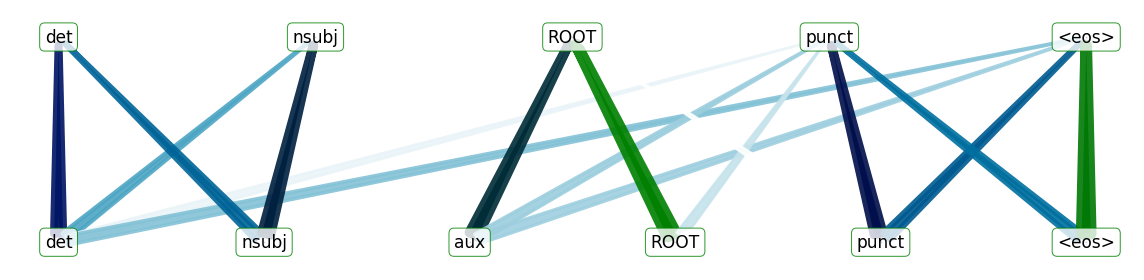

Sample n. 403


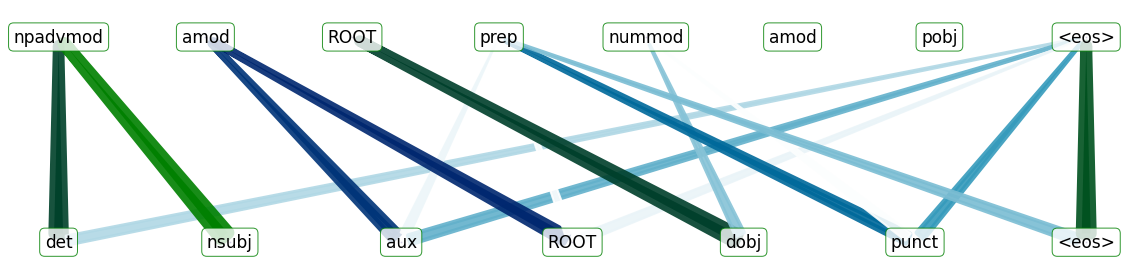

Sample n. 3139


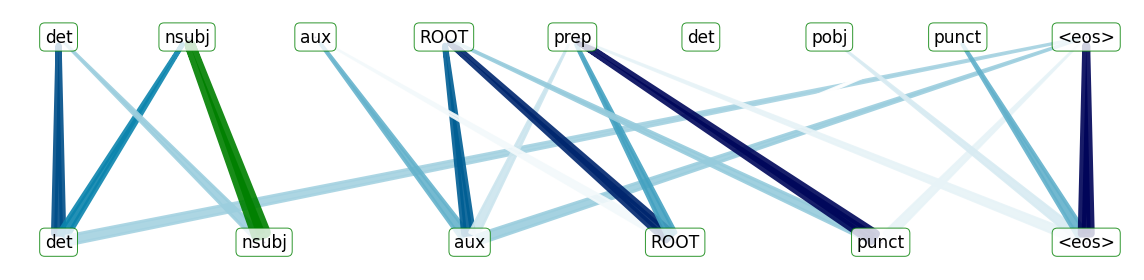

Sample n. 1452


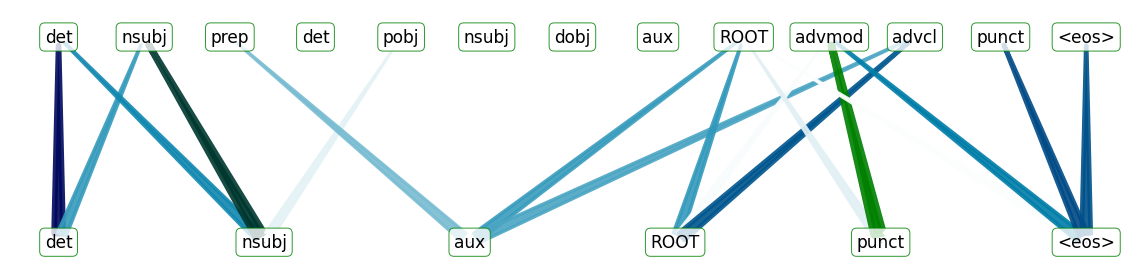

Sample n. 969


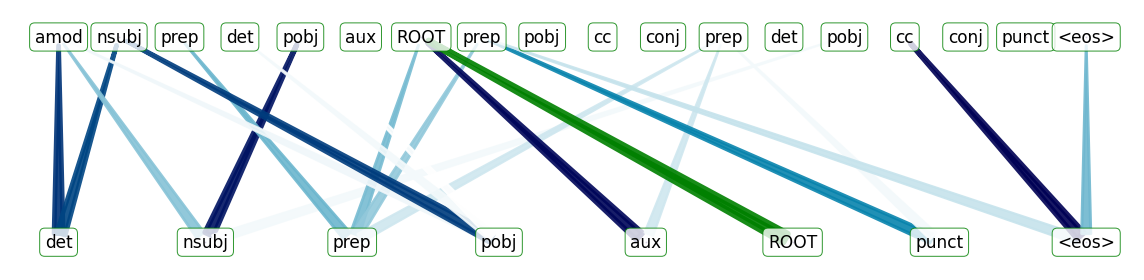

In [27]:
for index in random.sample(range(len(test_data)), k=5):
    print("Sample n.", index)
    premise, hypothesis = test_data[index]

    # predict the corresponding hypothesis
    pred_hypothesis, att_weights = predict(premise, model)
    draw_alignment(premise,pred_hypothesis, att_weights, tag ="dep_tag")